# Phần 1: Chuẩn bị dữ liệu – ChestX – ray14

## Bước 1.1: Tải dữ liệu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bước 1.2: Tách nhãn

In [2]:
import pandas as pd
import os

csv_path = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/Data_Entry_2017_v2020.csv'
image_folder = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/images'

df = pd.read_csv(csv_path)
df['Label'] = df['Finding Labels'].apply(lambda x: 1 if 'Nodule' in x else 0)

# Giữ lại các ảnh có tồn tại
available_images = set(os.listdir(image_folder))
df = df[df['Image Index'].isin(available_images)].reset_index(drop=True)

print('Số lượng ảnh:', len(df))
print('Số positive (Nodule):', df[df['Label'] == 1].shape[0])
print('Số negative (Non-nodule):', df[df['Label'] == 0].shape[0])

Số lượng ảnh: 14999
Số positive (Nodule): 666
Số negative (Non-nodule): 14333


## Bước 1.3: Chia dataset

In [3]:
from sklearn.model_selection import train_test_split

df_positive = df[df['Label'] == 1]
df_negative = df[df['Label'] == 0]

# In số lượng để biết trước khi chia
print('Số ảnh Positive (label = 1):', len(df_positive))
print('Số ảnh Negative (label = 0):', len(df_negative))

# Chia an toàn theo tỉ lệ nếu số lượng nhỏ
pos_train, pos_temp = train_test_split(df_positive, test_size=0.4, random_state=42)
pos_val, pos_test = train_test_split(pos_temp, test_size=0.5, random_state=42)

neg_train, neg_temp = train_test_split(df_negative, test_size=0.25, random_state=42)
neg_val, neg_test = train_test_split(neg_temp, test_size=0.5, random_state=42)

# Gộp lại
train_df = pd.concat([pos_train, neg_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([pos_val, neg_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print('Train:', train_df.shape)
print('Validation:', val_df.shape)
print('Test:', test_df.shape)


Số ảnh Positive (label = 1): 666
Số ảnh Negative (label = 0): 14333
Train: (11148, 12)
Validation: (1925, 12)
Test: (1926, 12)


# Phần 2: Tiền xử lý ảnh

In [4]:
import cv2
import numpy as np
from tqdm import tqdm
import os

# Thư mục ảnh gốc và thư mục lưu file .npy
image_folder = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/images'
output_folder = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/processed_npy'
os.makedirs(output_folder, exist_ok=True)

# Lọc lại các dataframe chỉ giữ ảnh có thật
available_images = set(os.listdir(image_folder))
for df_ in [train_df, val_df, test_df]:
    df_.drop(df_[~df_['Image Index'].isin(available_images)].index, inplace=True)
    df_.reset_index(drop=True, inplace=True)

# Chuẩn hóa theo ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[LỖI] Không đọc được ảnh: {image_path}")
        return None
    img = cv2.equalizeHist(img)
    img = cv2.medianBlur(img, 3)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.stack([img, img, img], axis=-1)
    for i in range(3):
        img[:, :, i] = (img[:, :, i] - imagenet_mean[i]) / imagenet_std[i]
    return img.astype(np.float32)

# Tiền xử lý cả 3 tập train/val/test
for subset_df, name in zip([train_df, val_df, test_df], ['train', 'val', 'test']):
    for idx, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f'Processing {name}'):
        image_name = row['Image Index']
        image_path = os.path.join(image_folder, image_name)
        processed_img = preprocess_image(image_path)
        if processed_img is not None:
            save_name = os.path.splitext(image_name)[0] + '.npy'
            save_path = os.path.join(output_folder, save_name)
            np.save(save_path, processed_img)
print()
print("Đã tiền xử lý toàn bộ ảnh và lưu dưới dạng .npy")

Processing test: 100%|██████████| 1926/1926 [01:16<00:00, 25.21it/s]


Đã tiền xử lý toàn bộ ảnh và lưu dưới dạng .npy


# Phần 3: Xây dựng và huấn luyện model A

## Bước 3.1: Tính class weights

In [6]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_df['Label'].values
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.5185598660340497), 1: np.float64(13.969924812030076)}


## Bước 3.2: Tạo custom generator đọc file .npy

In [7]:
import tensorflow as tf

class NPYDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, data_dir, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # ← Thêm dòng này
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            row = self.df.iloc[i]
            image_name = os.path.splitext(row['Image Index'])[0] + '.npy'
            image_path = os.path.join(self.data_dir, image_name)

            if not os.path.exists(image_path):
                print(f"[Cảnh báo] Thiếu file: {image_path} → Bỏ qua")
                continue

            image = np.load(image_path)
            label = row['Label']
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

## Bước 3.3: Tạo train & validation generator

In [8]:
train_generator = NPYDataGenerator(
    dataframe=train_df,
    batch_size=32,
    data_dir='/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/processed_npy/'
)

val_generator = NPYDataGenerator(
    dataframe=val_df,
    batch_size=32,
    data_dir='/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/processed_npy/',
    shuffle=False
)

## Bước 3.4: Xấy dựng mô hình DenseNet121

In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

base_model = DenseNet121(include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='imagenet')
x = layers.Dense(1, activation='sigmoid')(base_model.output)
model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Bước 3.5: Huấn luyện mô hình

In [10]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 406s 657ms/step - accuracy: 0.5664 - loss: 0.7442 - val_accuracy: 0.3761 - val_loss: 0.9194
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 167s 349ms/step - accuracy: 0.6912 - loss: 0.6063 - val_accuracy: 0.2686 - val_loss: 1.1692
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 118s 340ms/step - accuracy: 0.7587 - loss: 0.4686 - val_accuracy: 0.7662 - val_loss: 0.4873
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 119s 339ms/step - accuracy: 0.8544 - loss: 0.2979 - val_accuracy: 0.6109 - val_loss: 0.7614
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 142s 339ms/step - accuracy: 0.9021 - loss: 0.2013 - val_accuracy: 0.9174 - val_loss: 0.3054
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 118s 338ms/step - accuracy: 0.9375 - loss: 0.1307 - val_accuracy: 0.8784 - val_loss: 0.4139
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 116s 331ms/step - accuracy: 0.9194 - loss: 0.1591 - val_accuracy: 0.9055 - val_loss: 0.3669
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 119s 339ms/step - accuracy: 0.9310 -

## Bước 3.6: Lưu mô hình A

In [15]:
model_path = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/models/model_A_chestxray14.h5'
model.save(model_path)
print("Đã lưu Model A tại:", model_path)

Đã lưu Model A tại: /content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/models/model_A_chestxray14.h5


# Phần 4: Đánh giá mô hình trên tập kiểm tra (test set)

## 4.1: Đánh giá chỉ số Accuracy và Loss

In [16]:
test_generator = NPYDataGenerator(
    dataframe=test_df,
    batch_size=32,
    data_dir='/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/processed_npy/',
    shuffle=False
)

# Đánh giá mô hình
loss, accuracy = model.evaluate(test_generator)
print("Test accuracy:", accuracy)
print("Test loss:", loss)

61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.8207 - loss: 0.5031
Test accuracy: 0.8265835642814636
Test loss: 0.4903136193752289


# Phần 5: Dự đoán và trực quan hóa kết quả

## Bước 5.1: Vẽ Confusion Matrix

61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step


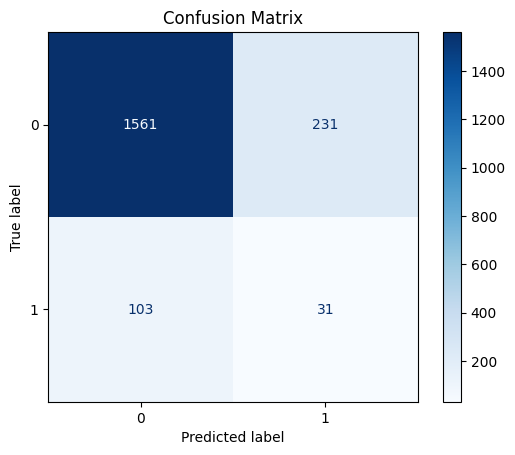

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán nhãn
y_true = test_df['Label'].values
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Bước 5.2: Hiển thị ảnh dự đoán sai

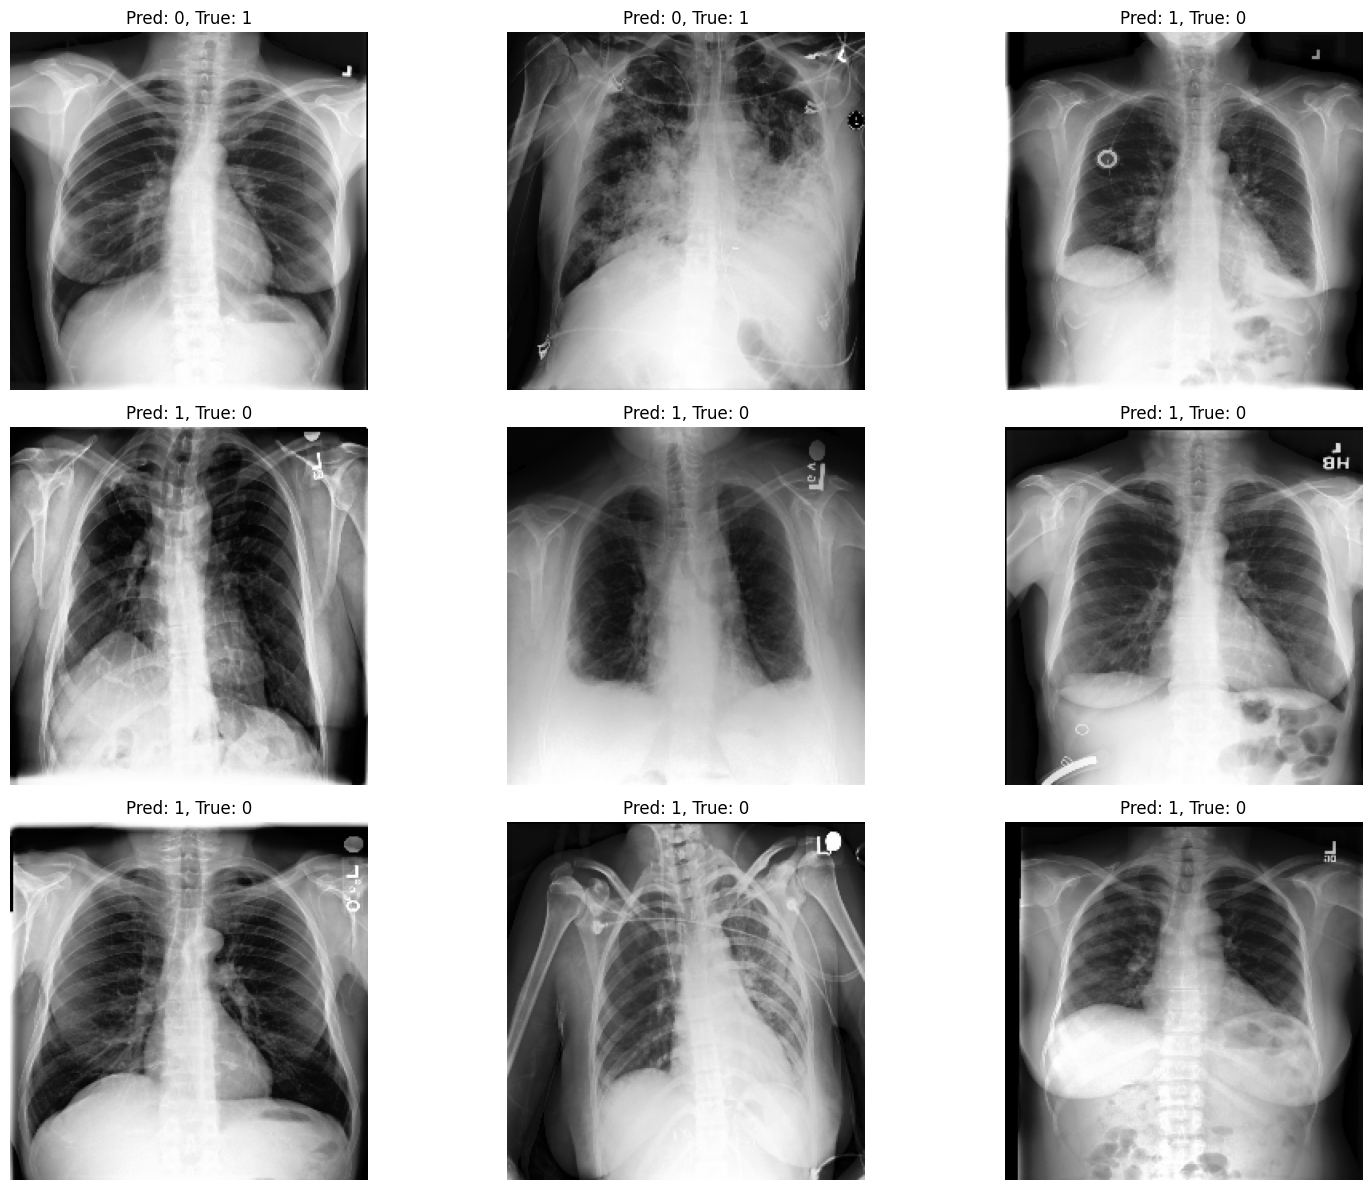

In [18]:
import random

wrong_indices = np.where(y_true != y_pred.reshape(-1))[0]
sample_wrong = random.sample(list(wrong_indices), min(9, len(wrong_indices)))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for idx, i in enumerate(sample_wrong):
    img_name = test_df.iloc[i]['Image Index']
    npy_path = os.path.join('/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/ChestX-ray14/processed_npy/', img_name.replace('.png', '.npy'))
    img = np.load(npy_path)
    axes[idx].imshow(img[:, :, 0], cmap='gray')
    axes[idx].set_title(f"Pred: {y_pred[i][0]}, True: {y_true[i]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()